In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import bbi
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import bioframe as bf
import cooltools
import cooltools.lib.plotting
import cooler
from tqdm import tqdm
from itertools import product
from scipy.ndimage import gaussian_filter
from spt5_project_lib import PeaksManipulation
from spt5_project_lib import PI

In [23]:
#### A way to use externel fonts in matplotlib without installing it
from matplotlib import font_manager
font_dirs = ['/users/ankit.gupta/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
#### A way to use externel fonts in matplotlib without installing it

mpl.rcParams['font.family'] = 'Nunito'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

In [5]:
tssOvlp = pd.read_csv("../atac_h3k27ac_peaks_overlap/promoter_peaks_using_h3k27ac.tsv",sep="\t")
intergenic = pd.read_csv("../atac_h3k27ac_peaks_overlap/enhancer_peaks_using_h3k27ac.tsv",sep="\t")

In [6]:
genes = pd.read_csv("../../results/files/mm9.genes.info.csv")
# genes = genes.drop_duplicates(subset=["gene_name"])
genes["gene_len"] = abs(genes.end - genes.start)
genes = genes.rename(columns={"gene_name":"gene_name_"})

In [7]:
genes

,chrom,start,end,gene_name_,strand,gene_len
0,chr1,3044314,3044814,Gm16088,+,500
1,chr1,3092097,3092206,U6,+,109
2,chr1,3195982,3661579,Xkr4,-,465597
3,chr1,3456668,3503634,Gm1992,+,46966
4,chr1,3668961,3669024,U7,-,63
...,...,...,...,...,...,...
37578,chrY,2086590,2097768,Rbmy1a1,+,11178
37579,chrY,2118049,2129045,Gm10256,+,10996
37580,chrY,2156899,2168120,Gm10352,+,11221
37581,chrY,2390390,2398856,Gm3376,+,8466


In [9]:
intergenic = PeaksManipulation.GetIntervalsFromPeaks(intergenic,500)
intergenic

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance
0,chr1,7067249,7068249,2688,chr1,7079001,7163707,Pcmtd1,+,84706,9908
1,chr1,9628845,9629845,1634,chr1,9550913,9621256,2610203C22Rik,-,70343,7272
2,chr1,12992303,12993303,1000,chr1,12856630,12981258,Slco5a1,-,124628,11045
3,chr1,13042006,13043006,1119,chr1,13103538,13117244,Prdm14,-,13706,60472
4,chr1,13373285,13374285,2054,chr1,13129186,13364164,Ncoa2,-,234978,8594
...,...,...,...,...,...,...,...,...,...,...,...
5581,chrX,104521668,104522668,1280,chrX,104539925,104540951,Gm14833,+,1026,17117
5582,chrX,127278793,127279793,1029,chrX,127422205,127422314,AL671906.1,-,109,142397
5583,chrX,147391191,147392191,1000,chrX,147417684,147451865,Gnl3l,-,34181,25493
5584,chrX,160317335,160318335,1131,chrX,160346949,160371598,Ap1s2,+,24649,28548


## MicroC

In [14]:
microCRes = 1000
cools = {}
cools["WT"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/WT.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
cools["KO"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/KO.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
mm9_chromsizes = bf.fetch_chromsizes('mm9')
mm9_cens = bf.fetch_centromeres('mm9') ### Mouse chromosomes are telocentric
mm9_chroms = bf.core.construction.add_ucsc_name_column(bf.make_chromarms(mm9_chromsizes,  mm9_cens))
mm9_chroms = mm9_chroms[mm9_chroms.chrom.isin(cools["WT"].chromnames)].reset_index(drop=True)

In [15]:
%%time
expectedWT = pd.read_csv("../microC_pileups/expected_cis_WT_group_1kb_res.tsv",sep="\t")
expectedKO = pd.read_csv("../microC_pileups/expected_cis_KO_group_1kb_res.tsv",sep="\t")

loopsFlankbig = 40_000
tssPileup = {}
tssPileup = dict(WT=cooltools.pileup(cools["WT"], intergenic, view_df=mm9_chroms,expected_df=expectedWT, flank=loopsFlankbig, nproc=10), 
                 KO=cooltools.pileup(cools["KO"], intergenic, view_df=mm9_chroms,expected_df=expectedKO, flank=loopsFlankbig, nproc=10))

CPU times: user 46.6 s, sys: 21.7 s, total: 1min 8s
Wall time: 7min 32s


---

## Getting Pileups

In [16]:
pileupsDict = {}

<20kb	4337


<timed exec>:30: RuntimeWarning: divide by zero encountered in log10
<timed exec>:39: RuntimeWarning: divide by zero encountered in log10
<timed exec>:47: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 6.85 s, sys: 2.85 s, total: 9.7 s
Wall time: 8.33 s


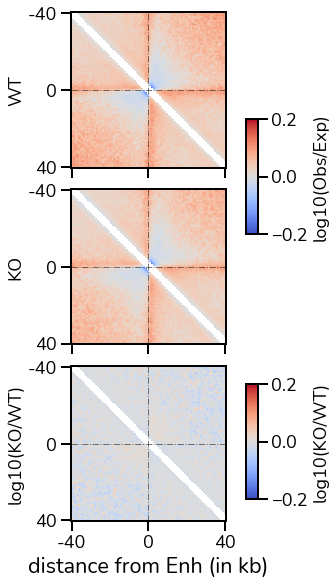

In [27]:
%%time

pileupKwargsDictOE = dict(cmap="coolwarm",aspect="auto",vmin=-0.20,vmax=0.20)
pileupKwargsDictRatio = dict(cmap="coolwarm",aspect="auto",vmin=-0.2,vmax=0.2)

fig,ax = plt.subplots(3,1,figsize=(4,8),sharex=True,sharey=True,constrained_layout=True)
distRanges = {
              ">10kb": "(10_000 < distance)",
             }
centerAt = loopsFlankbig // microCRes
ax[0].set_xticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_yticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])

ax[0].set_ylabel("WT")
ax[1].set_ylabel("KO")
ax[2].set_ylabel("log10(KO/WT)")
for ic,i in enumerate(distRanges.keys()):
    
    # ax[0].set_title(i)
    pileupKwargsDict = pileupKwargsDictOE
    df = intergenic.query(distRanges[i],engine="python")
    print(i,len(df),sep="\t")
    mask = np.array(df.strand_ == '-', dtype=bool)

    covWT = tssPileup["WT"][:,:,list(df.index)].copy()
    covWT[:, :, mask] = covWT[::-1, ::-1, mask]
    ax[0].imshow(np.log10(np.nanmean(covWT,axis=2)),**pileupKwargsDict)
    ax[0].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[0].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[0].set_aspect(1)
    # ax[0].spines.bottom.set_visible(False)
    # ax[0].spines.left.set_visible(False)

    covKO = tssPileup["KO"][:,:,list(df.index)].copy()
    covKO[:, :, mask] = covKO[::-1, ::-1, mask]
    ax[1].imshow(np.log10(np.nanmean(covKO,axis=2)),**pileupKwargsDict)
    ax[1].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[1].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[1].set_aspect(1)
    # ax[1].spines.bottom.set_visible(False)
    # ax[1].spines.left.set_visible(False)
    
    pileupKwargsDict = pileupKwargsDictRatio
    ratio = np.log10(np.nanmean(covKO,axis=2)/np.nanmean(covWT,axis=2))
    ax[2].imshow(ratio,**pileupKwargsDict)
    ax[2].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[2].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[2].set_aspect(1)
    # ax[2].spines.bottom.set_visible(False)
    # ax[2].spines.left.set_visible(False)

ax2 = fig.add_axes([0.84, 0.6,0.04, 0.2])
cb2 = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.20, 0.20),label="log10(Obs/Exp)")

ax3 = fig.add_axes([0.84, 0.14,0.04, 0.2])
cb3 = mpl.colorbar.ColorbarBase(ax3, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.20, 0.20),label="log10(KO/WT)")

fig.supxlabel("distance from Enh (in kb)")

# plt.savefig("microC_pileup_at_enh.png",dpi=300,bbox_inches="tight")
# plt.savefig("microC_pileup_at_enh.pdf",dpi=300,bbox_inches="tight")